In [1]:
import numpy as np
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier

from helper import load_data, write_to_csv, set_sepcial_observation
import DataPreprocessor 
#from handcraft_logistic_regression import LogisticRegression

In [19]:
import importlib
importlib.reload(DataPreprocessor)

<module 'DataPreprocessor' from 'd:\\Coding\\NTU\\110-1\\EEML\\HW2\\DataPreprocessor.py'>

In [2]:
data_path = "./data/"
path_train = os.path.join(data_path, "train.csv")
path_test = os.path.join(data_path, "test.csv")
data_train, data_test = load_data(path_train, path_test)

In [3]:
label_dict = {'<=50K': 0, '>50K': 1}
data_train["income"] = data_train["income"].apply(lambda x: label_dict[x])

In [3]:
DP = DataPreprocessor.DataPreprocessor()
X_train, y_train = DP.preprocess_train_data(data_train)
X_test= DP.preprocess_test_data(data_test)

(32561, 103)
(16281, 103)


/content/gdrive/MyDrive/EEML/HW2/DataPreprocessor.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cat["native_country"] = data_cat["native_country"].astype(pd.CategoricalDtype(categories=self.all_native_countries))


In [4]:
print(X_train.shape)
print(X_test.shape)

NameError: name 'X_train' is not defined

In [4]:
def frequency_encoding(data, col):
    cat_ratio = data.groupby([col]).size() / len(data)
    return cat_ratio

In [8]:
cat_ratio = data_train.groupby(["workclass"]).size() / len(data_train)
data_train["workclass"] = data_train["workclass"].apply(lambda x: cat_ratio[x])

# KNN

In [29]:
cond1 = (data_test["education_num"] == 1)
cond2 = (data_test["workclass"] == "Never-worked")
special_index = data_test[cond1 | cond2].index.tolist()

# All features
## Numerical
- robust scaling
## Categorical
- one-hot

## KNN


In [5]:
k_max = round(np.sqrt(X_train.shape[0]))
k_range = list(range(20, k_max, 3))
param_grid = {
    "n_neighbors": k_range,
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"]
}

In [6]:
KNN = KNeighborsClassifier()
GS = GridSearchCV(KNN, 
    param_grid, 
    verbose = 1,
    cv = 5, n_jobs = -1).fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   59.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 20.9min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed: 29.7min finished


In [10]:
GS.score(X_train, y_train)

0.9999692884125181

In [14]:
GS.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=32, p=2,
                     weights='distance')

param_n_neighbors
20     0.798517
23     0.799008
26     0.799177
29     0.800152
32     0.799876
35     0.799929
38     0.799192
41     0.799162
44     0.798440
47     0.798263
50     0.797672
53     0.797557
56     0.796843
59     0.796666
62     0.796336
65     0.796144
68     0.795653
71     0.795215
74     0.794578
77     0.794301
80     0.793664
83     0.793334
86     0.792904
89     0.792651
92     0.792274
95     0.791998
98     0.791468
101    0.791253
104    0.790693
107    0.790347
110    0.789925
113    0.789710
116    0.789388
119    0.789104
122    0.788666
125    0.788466
128    0.787975
131    0.787576
134    0.787031
137    0.786754
140    0.786316
143    0.786094
146    0.785633
149    0.785395
152    0.784904
155    0.784681
158    0.784259
161    0.784113
164    0.783675
167    0.783476
170    0.783192
173    0.783046
176    0.782792
179    0.782554
Name: mean_test_score, dtype: float64


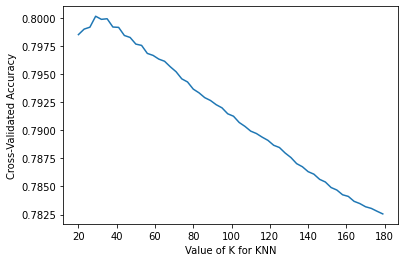

In [8]:
GS_result = pd.DataFrame(GS.cv_results_)
print(GS_result.groupby(["param_n_neighbors"])['mean_test_score'].mean())

k_idx = GS_result.groupby(["param_n_neighbors"])['mean_test_score'].mean().index
acc = GS_result.groupby(["param_n_neighbors"])['mean_test_score'].mean().values

plt.plot(k_idx, acc)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

In [26]:
y_pred = GS.predict(X_test)
print(f"Before hard labeling, ratio of income >50K = {y_pred.sum() / y_pred.shape[0]}")
y_pred = set_sepcial_observation(y_pred, special_index)
print(f"After hard labeling, ratio of income >50K = {y_pred.sum() / y_pred.shape[0]}")

Before hard labeling, ratio of income >50K = 0.07579387015539586
After hard labeling, ratio of income >50K = 0.07573244886677723


In [27]:
#記得改名字
file_name = 'submission_1025_4.csv'
write_to_csv(y_pred, file_name)

## K-means

# Selected features
## Numerical
- robust scaling
## Categorical
- one-hot
- remove some features and categories

## KNN

In [66]:
k_max = round(np.sqrt(X_train.shape[0]))
k_range = list(range(20, k_max, 3))
param_grid = {
    "n_neighbors": k_range,
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"]
}

In [67]:
KNN = KNeighborsClassifier()
GS = GridSearchCV(KNN, 
    param_grid, 
    verbose = 1,
    cv = 5)

In [68]:
GS.fit(X_train, y_train)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed: 15.2min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [25, 27, 29, 31, 33, 35, 37, 39, 41, 43,
                                         45, 47, 49, 51],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [69]:
GS.score(X_train, y_train)

0.8689044088238009

In [72]:
GS.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=35, p=2,
                     weights='uniform')

param_n_neighbors
25    0.858213
27    0.858175
29    0.858013
31    0.858136
33    0.858167
35    0.858321
37    0.858190
39    0.858121
41    0.858090
43    0.857859
45    0.858313
47    0.858344
49    0.858136
51    0.857959
Name: mean_test_score, dtype: float64


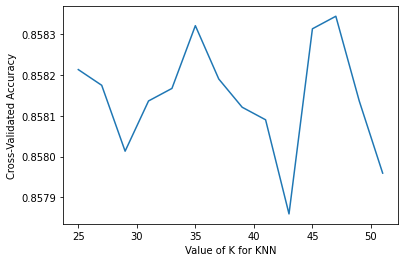

In [73]:
GS_result = pd.DataFrame(GS.cv_results_)
print(GS_result.groupby(["param_n_neighbors"])['mean_test_score'].mean())

k_idx = GS_result.groupby(["param_n_neighbors"])['mean_test_score'].mean().index
acc = GS_result.groupby(["param_n_neighbors"])['mean_test_score'].mean().values

plt.plot(k_idx, acc)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

In [74]:
y_pred = GS.predict(X_test)
print(f"Before hard labeling, ratio of income >50K = {y_pred.sum() / y_pred.shape[0]}")
y_pred = set_sepcial_observation(y_pred, special_index)
print(f"After hard labeling, ratio of income >50K = {y_pred.sum() / y_pred.shape[0]}")

Before hard labeling, ratio of income >50K = 0.19783797064062403
After hard labeling, ratio of income >50K = 0.1977765493520054


In [ ]:
#記得改名字
file_name = 'submission_1025_3.csv'
write_to_csv(y_pred, file_name)

## K-means

# Selected featuers
- Numerical features
    - robust scaler (do not scale `education_num`)
- Categorical
    - frequency encoding (mean)

In [4]:
num_cols = ["age", "fnlwgt", "capital_gain", "capital_loss", "hours_per_week"]
order_cat_cols = ["education_num"]
cat_cols = ["workclass", "education", "marital_status", "occupation", "relationship", "race", "sex", "native_country"]

#use training data's frequency to apply on training and testing dataset
for col in cat_cols:
    cat_ratio = data_train.groupby([col]).size() / len(data_train)
    data_train[col] = data_train[col].apply(lambda x: cat_ratio[x])
    data_test[col] = data_test[col].apply(lambda x: cat_ratio[x])

In [5]:
y_train = data_train["income"]

X_train_order = np.array(data_train[order_cat_cols])
X_train_num = np.array(data_train[num_cols])
X_train_cat = np.array(data_train[cat_cols])

X_test_order = np.array(data_test[order_cat_cols])
X_test_num = np.array(data_test[num_cols])
X_test_cat = np.array(data_test[cat_cols])

In [6]:
robust_scaler = RobustScaler()
X_train_num_scaled = robust_scaler.fit_transform(X_train_num)
X_test_num_scaled = robust_scaler.transform(X_test_num)

In [7]:
X_train = np.concatenate([X_train_order, X_train_num_scaled, X_train_cat], axis = 1)
X_test = np.concatenate([X_test_order, X_test_num_scaled, X_test_cat], axis = 1)

In [8]:
print(X_train.shape)
print(X_test.shape)

(32561, 14)
(16281, 14)


In [9]:
k_max = round(np.sqrt(X_train_num.shape[0]))
k_range = list(range(20, k_max, 3))
param_grid = {
    "n_neighbors": k_range,
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"]
}

In [10]:
KNN = KNeighborsClassifier()
GS = GridSearchCV(KNN, 
    param_grid,     
    verbose = 1,
    cv = 5, n_jobs = -1).fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 20.9min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 40.3min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed: 64.3min finished


Training accuracy 0.9999692884125181
========== Best estimator is ==========
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=53, p=2,
                     weights='distance')
========== CV Acc for each K ==========
param_n_neighbors
20     0.850934
23     0.851510
26     0.851978
29     0.851986
32     0.851732
35     0.851656
38     0.851433
41     0.851310
44     0.851226
47     0.851034
50     0.850949
53     0.851149
56     0.850965
59     0.851110
62     0.850535
65     0.849836
68     0.849751
71     0.849536
74     0.849298
77     0.849129
80     0.848922
83     0.848884
86     0.849045
89     0.848769
92     0.848999
95     0.848784
98     0.848607
101    0.848469
104    0.848331
107    0.848024
110    0.847732
113    0.847617
116    0.847602
119    0.847417
122    0.847471
125    0.847356
128    0.847287
131    0.847218
134    0.847018
137    0.846788
140    0.846335
143    0.845982
146 

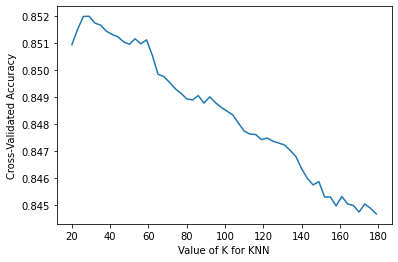

In [11]:
print(f"Training accuracy {GS.score(X_train, y_train)}")
print("="*10, "Best estimator is", "="*10)
print(GS.best_estimator_)

GS_result = pd.DataFrame(GS.cv_results_)
print("="*10, "CV Acc for each K", "="*10)
print(GS_result.groupby(["param_n_neighbors"])['mean_test_score'].mean())

k_idx = GS_result.groupby(["param_n_neighbors"])['mean_test_score'].mean().index
acc = GS_result.groupby(["param_n_neighbors"])['mean_test_score'].mean().values

plt.plot(k_idx, acc)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

# Selected featuers
- Numerical features
    - robust scaler (do not scale `education_num`)
- Categorical
    - frequency encoding (sum)

In [6]:
num_cols = ["age", "fnlwgt", "capital_gain", "capital_loss", "hours_per_week"]
order_cat_cols = ["education_num"]
cat_cols = ["workclass", "education", "marital_status", "occupation", "relationship", "race", "sex", "native_country"]

#use training data's frequency to apply on training and testing dataset
for col in cat_cols:
    cat_ratio = data_train.groupby([col]).size()
    data_train[col] = data_train[col].apply(lambda x: cat_ratio[x])
    data_test[col] = data_test[col].apply(lambda x: cat_ratio[x])

In [7]:
y_train = data_train["income"]

X_train_order = np.array(data_train[order_cat_cols])
X_train_num = np.array(data_train[num_cols])
X_train_cat = np.array(data_train[cat_cols])

X_test_order = np.array(data_test[order_cat_cols])
X_test_num = np.array(data_test[num_cols])
X_test_cat = np.array(data_test[cat_cols])

In [9]:
robust_scaler = RobustScaler()
X_train_num_scaled = robust_scaler.fit_transform(X_train_num)
X_test_num_scaled = robust_scaler.transform(X_test_num)

In [10]:
X_train = np.concatenate([X_train_order, X_train_num_scaled, X_train_cat], axis = 1)
X_test = np.concatenate([X_test_order, X_test_num_scaled, X_test_cat], axis = 1)

In [11]:
print(X_train.shape)
print(X_test.shape)

(32561, 14)
(16281, 14)


In [12]:
k_max = 100
# k_max = round(np.sqrt(X_train_num.shape[0]))
k_range = list(range(20, k_max, 3))
param_grid = {
    "n_neighbors": k_range,
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"]
}

In [13]:
KNN = KNeighborsClassifier()
GS = GridSearchCV(KNN, 
    param_grid,     
    verbose = 1,
    cv = 5, n_jobs = -1).fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 28.5min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 35.0min finished


Training accuracy 0.8564233285218513
========== Best estimator is ==========
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                     weights='uniform')
========== CV Acc for each K ==========
param_n_neighbors
20    0.840523
23    0.839908
26    0.839563
29    0.838695
32    0.838680
35    0.838327
38    0.838066
41    0.837743
44    0.836960
47    0.836830
50    0.836438
53    0.835985
56    0.835701
59    0.835701
62    0.835570
65    0.835148
68    0.835401
71    0.835363
74    0.835041
77    0.835186
80    0.834964
83    0.835002
86    0.834595
89    0.834526
92    0.833282
95    0.833413
98    0.833060
Name: mean_test_score, dtype: float64


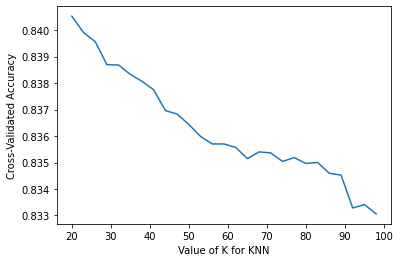

In [14]:
print(f"Training accuracy {GS.score(X_train, y_train)}")
print("="*10, "Best estimator is", "="*10)
print(GS.best_estimator_)

GS_result = pd.DataFrame(GS.cv_results_)
print("="*10, "CV Acc for each K", "="*10)
print(GS_result.groupby(["param_n_neighbors"])['mean_test_score'].mean())

k_idx = GS_result.groupby(["param_n_neighbors"])['mean_test_score'].mean().index
acc = GS_result.groupby(["param_n_neighbors"])['mean_test_score'].mean().values

plt.plot(k_idx, acc)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

# Selected featuers
- Numerical features
    - robust scaler (do not scale `education_num`)
- Categorical
    - target encoding (mean)

In [5]:
num_cols = ["age", "fnlwgt", "capital_gain", "capital_loss", "hours_per_week"]
order_cat_cols = ["education_num"]
cat_cols = ["workclass", "education", "marital_status", "occupation", "relationship", "race", "sex", "native_country"]

#use training data's frequency to apply on training and testing dataset
for col in cat_cols:
    target_ratio = data_train[[col, "income"]].groupby([col]).mean()
    data_train[col] = data_train[col].apply(lambda x: target_ratio["income"][x])
    data_test[col] = data_test[col].apply(lambda x: target_ratio["income"][x])

In [6]:
y_train = data_train["income"]

X_train_order = np.array(data_train[order_cat_cols])
X_train_num = np.array(data_train[num_cols])
X_train_cat = np.array(data_train[cat_cols])

X_test_order = np.array(data_test[order_cat_cols])
X_test_num = np.array(data_test[num_cols])
X_test_cat = np.array(data_test[cat_cols])

In [7]:
robust_scaler = RobustScaler()
X_train_num_scaled = robust_scaler.fit_transform(X_train_num)
X_test_num_scaled = robust_scaler.transform(X_test_num)

In [8]:
X_train = np.concatenate([X_train_order, X_train_num_scaled, X_train_cat], axis = 1)
X_test = np.concatenate([X_test_order, X_test_num_scaled, X_test_cat], axis = 1)

In [9]:
print(X_train.shape)
print(X_test.shape)

(32561, 14)
(16281, 14)


In [9]:
k_max = round(np.sqrt(X_train.shape[0]))
k_range = list(range(20, k_max, 3))
param_grid = {
    "n_neighbors": k_range,
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"]
}

In [ ]:
KNN = KNeighborsClassifier()
GS = GridSearchCV(KNN, 
    param_grid,     
    verbose = 1,
    cv = 5, n_jobs = -1).fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 25.9min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 47.7min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed: 68.4min finished


Training accuracy 0.9999692884125181
========== Best estimator is ==========
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                     weights='distance')
========== CV Acc for each K ==========
param_n_neighbors
20     0.858850
23     0.859587
26     0.859303
29     0.859495
32     0.858880
35     0.858950
38     0.858497
41     0.858236
44     0.858220
47     0.858604
50     0.858435
53     0.858182
56     0.857967
59     0.857283
62     0.857214
65     0.856754
68     0.856316
71     0.856139
74     0.855510
77     0.855510
80     0.855425
83     0.855264
86     0.855433
89     0.855387
92     0.855418
95     0.855157
98     0.854965
101    0.854896
104    0.855034
107    0.854980
110    0.854765
113    0.854420
116    0.854258
119    0.854212
122    0.854258
125    0.854135
128    0.854143
131    0.853652
134    0.853882
137    0.853744
140    0.853283
143    0.852961
146 

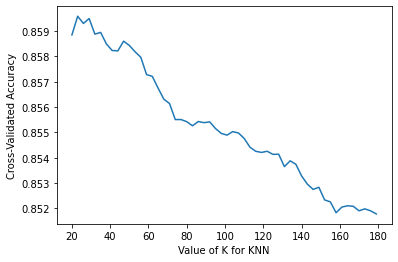

In [ ]:
print(f"Training accuracy {GS.score(X_train, y_train)}")
print("="*10, "Best estimator is", "="*10)
print(GS.best_estimator_)

GS_result = pd.DataFrame(GS.cv_results_)
print("="*10, "CV Acc for each K", "="*10)
print(GS_result.groupby(["param_n_neighbors"])['mean_test_score'].mean())

k_idx = GS_result.groupby(["param_n_neighbors"])['mean_test_score'].mean().index
acc = GS_result.groupby(["param_n_neighbors"])['mean_test_score'].mean().values

plt.plot(k_idx, acc)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

# Selected featuers
- Numerical features
    - robust scaler (do not scale `education_num`)
- Categorical
    - target encoding (sum)

In [23]:
num_cols = ["age", "fnlwgt", "capital_gain", "capital_loss", "hours_per_week"]
order_cat_cols = ["education_num"]
cat_cols = ["workclass", "education", "marital_status", "occupation", "relationship", "race", "sex", "native_country"]

#use training data's frequency to apply on training and testing dataset
for col in cat_cols:
    target_ratio = data_train[[col, "income"]].groupby([col]).sum()
    data_train[col] = data_train[col].apply(lambda x: target_ratio["income"][x])
    data_test[col] = data_test[col].apply(lambda x: target_ratio["income"][x])

In [24]:
y_train = data_train["income"]

X_train_order = np.array(data_train[order_cat_cols])
X_train_num = np.array(data_train[num_cols])
X_train_cat = np.array(data_train[cat_cols])

X_test_order = np.array(data_test[order_cat_cols])
X_test_num = np.array(data_test[num_cols])
X_test_cat = np.array(data_test[cat_cols])

In [25]:
robust_scaler = RobustScaler()
X_train_num_scaled = robust_scaler.fit_transform(X_train_num)
X_test_num_scaled = robust_scaler.transform(X_test_num)

In [26]:
X_train = np.concatenate([X_train_order, X_train_num_scaled, X_train_cat], axis = 1)
X_test = np.concatenate([X_test_order, X_test_num_scaled, X_test_cat], axis = 1)

In [27]:
print(X_train.shape)
print(X_test.shape)

(32561, 14)
(16281, 14)


In [28]:
k_max = 100
k_range = list(range(20, k_max, 3))
param_grid = {
    "n_neighbors": k_range,
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"]
}

In [29]:
KNN = KNeighborsClassifier()
GS = GridSearchCV(KNN, 
    param_grid,     
    verbose = 1,
    cv = 5, n_jobs = -1).fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 29.4min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 36.2min finished


Training accuracy 0.8629341850680262
========== Best estimator is ==========
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                     weights='uniform')
========== CV Acc for each K ==========
param_n_neighbors
20    0.847310
23    0.846619
26    0.846657
29    0.845882
32    0.845820
35    0.845997
38    0.846396
41    0.846273
44    0.845644
47    0.845920
50    0.845859
53    0.845552
56    0.845436
59    0.845298
62    0.845529
65    0.845206
68    0.845168
71    0.845198
74    0.845214
77    0.845521
80    0.845275
83    0.844976
86    0.844500
89    0.844431
92    0.843985
95    0.843686
98    0.843724
Name: mean_test_score, dtype: float64


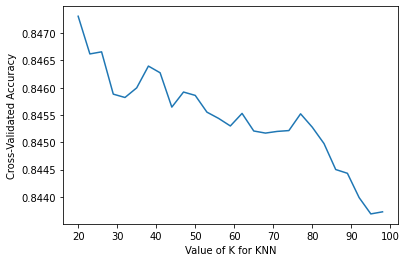

In [30]:
print(f"Training accuracy {GS.score(X_train, y_train)}")
print("="*10, "Best estimator is", "="*10)
print(GS.best_estimator_)

GS_result = pd.DataFrame(GS.cv_results_)
print("="*10, "CV Acc for each K", "="*10)
print(GS_result.groupby(["param_n_neighbors"])['mean_test_score'].mean())

k_idx = GS_result.groupby(["param_n_neighbors"])['mean_test_score'].mean().index
acc = GS_result.groupby(["param_n_neighbors"])['mean_test_score'].mean().values

plt.plot(k_idx, acc)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

# Random forest

# Selected featuers
- Numerical features
    - robust scaler (do not scale `education_num`)
- Categorical
    - frequency encoding (mean)

In [71]:
num_cols = ["age", "fnlwgt", "capital_gain", "capital_loss", "hours_per_week"]
order_cat_cols = ["education_num"]
cat_cols = ["workclass", "education", "marital_status", "occupation", "relationship", "race", "sex", "native_country"]

#use training data's frequency to apply on training and testing dataset
for col in cat_cols:
    cat_ratio = data_train.groupby([col]).size() / len(data_train)
    data_train[col] = data_train[col].apply(lambda x: cat_ratio[x])
    data_test[col] = data_test[col].apply(lambda x: cat_ratio[x])

In [72]:
y_train = data_train["income"]

X_train_order = np.array(data_train[order_cat_cols])
X_train_num = np.array(data_train[num_cols])
X_train_cat = np.array(data_train[cat_cols])

X_test_order = np.array(data_test[order_cat_cols])
X_test_num = np.array(data_test[num_cols])
X_test_cat = np.array(data_test[cat_cols])

In [73]:
robust_scaler = RobustScaler()
X_train_num_scaled = robust_scaler.fit_transform(X_train_num)
X_test_num_scaled = robust_scaler.transform(X_test_num)

In [74]:
X_train = np.concatenate([X_train_order, X_train_num_scaled, X_train_cat], axis = 1)
X_test = np.concatenate([X_test_order, X_test_num_scaled, X_test_cat], axis = 1)

In [75]:
print(X_train.shape)
print(X_test.shape)

(32561, 14)
(16281, 14)


In [76]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 250, num = 5)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 10, num = 6)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
params_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'oob_score': [True]}
print(params_grid)

{'n_estimators': [100, 137, 175, 212, 250], 'max_depth': [5, 6, 7, 8, 9, 10], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2, 4], 'oob_score': [True]}


In [79]:
RFC = RandomForestClassifier(random_state = 201)
RFC_CV = GridSearchCV(estimator = RFC, param_grid = params_grid, cv = 5, verbose = 2, n_jobs = -1)
RFC_CV.fit(X_train, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 18.5min


In [ ]:
print(f"Training Accuracy = {round(RFC_CV.score(X_train, y_train) * 100, 4)}%")
RFC_CV.best_estimator_

Training Accuracy = 82.1136%


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=212,
                       n_jobs=None, oob_score=True, random_state=201, verbose=0,
                       warm_start=False)

In [ ]:
RFC_CV_result = pd.DataFrame(RFC_CV.cv_results_)
RFC_CV_result[RFC_CV_result["rank_test_score"] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,param_oob_score,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
153,9.672122,0.08862,0.347762,0.042471,10,1,2,212,True,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...",0.858744,0.864097,0.86594,0.868857,0.866554,0.864838,0.003406,1


In [ ]:
with open('model/RFC_CV_1027_3.pickle', 'wb') as f:
    pickle.dump(RFC_CV, f)

# Selected featuers
- Numerical features
    - robust scaler (do not scale `education_num`)
- Categorical
    - target encoding (sum)

In [19]:
num_cols = ["age", "fnlwgt", "capital_gain", "capital_loss", "hours_per_week"]
order_cat_cols = ["education_num"]
cat_cols = ["workclass", "education", "marital_status", "occupation", "relationship", "race", "sex", "native_country"]

#use training data's frequency to apply on training and testing dataset
for col in cat_cols:
    target_ratio = data_train[[col, "income"]].groupby([col]).sum()
    data_train[col] = data_train[col].apply(lambda x: target_ratio["income"][x])
    data_test[col] = data_test[col].apply(lambda x: target_ratio["income"][x])

In [20]:
y_train = data_train["income"]

X_train_order = np.array(data_train[order_cat_cols])
X_train_num = np.array(data_train[num_cols])
X_train_cat = np.array(data_train[cat_cols])

X_test_order = np.array(data_test[order_cat_cols])
X_test_num = np.array(data_test[num_cols])
X_test_cat = np.array(data_test[cat_cols])

In [21]:
robust_scaler = RobustScaler()
X_train_num_scaled = robust_scaler.fit_transform(X_train_num)
X_test_num_scaled = robust_scaler.transform(X_test_num)

In [22]:
X_train = np.concatenate([X_train_order, X_train_num_scaled, X_train_cat], axis = 1)
X_test = np.concatenate([X_test_order, X_test_num_scaled, X_test_cat], axis = 1)

In [23]:
print(X_train.shape)
print(X_test.shape)

(32561, 14)
(16281, 14)


In [39]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 250, num = 5)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 10, num = 6)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
params_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'oob_score': [True]}
print(params_grid)

{'n_estimators': [100, 137, 175, 212, 250], 'max_depth': [5, 6, 7, 8, 9, 10], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2, 4], 'oob_score': [True]}


In [40]:
RFC = RandomForestClassifier(random_state = 201)
RFC_CV = GridSearchCV(estimator = RFC, param_grid = params_grid, cv = 5, verbose = 2, n_jobs = -1)
RFC_CV.fit(X_train, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 18.2min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 35.3min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 52.7min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=201,
                                 

In [41]:
print(f"Training Accuracy = {round(RFC_CV.score(X_train, y_train) * 100, 4)}%")

Training Accuracy = 87.2547%


In [44]:
RFC_CV.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=212,
                       n_jobs=None, oob_score=True, random_state=201, verbose=0,
                       warm_start=False)

In [51]:
RFC_CV_result = pd.DataFrame(RFC_CV.cv_results_)
RFC_CV_result[RFC_CV_result["rank_test_score"] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
54,2.550517,0.23744,4.96541,0.031826,manhattan,20,uniform,"{'metric': 'manhattan', 'n_neighbors': 20, 'we...",0.843851,0.848894,0.849662,0.854883,0.850737,0.849606,0.003543,1


In [43]:
with open('model/RFC_CV_1027.pickle', 'wb') as f:
    pickle.dump(RFC_CV, f)

In [15]:
loaded_model = pickle.load(open("model/RFC_CV_1027.pickle", 'rb'))

In [26]:
y_pred = loaded_model.predict(X_test)
print(f"Before hard labeling, ratio of income >50K = {y_pred.sum() / y_pred.shape[0]}")
y_pred_2 = set_sepcial_observation(y_pred, special_index)
print(f"After hard labeling, ratio of income >50K = {y_pred_2.sum() / y_pred.shape[0]}")

Before hard labeling, ratio of income >50K = 0.16798722437196734
After hard labeling, ratio of income >50K = 0.1679258030833487


In [27]:
file_name = 'submission_1028_1.csv'
write_to_csv(y_pred, file_name)
file_name = 'submission_1028_2.csv'
write_to_csv(y_pred_2, file_name)

# Selected featuers
- Numerical features
    - robust scaler (do not scale `education_num`)
- Categorical
    - target encoding (mean)

In [17]:
num_cols = ["age", "fnlwgt", "capital_gain", "capital_loss", "hours_per_week"]
order_cat_cols = ["education_num"]
cat_cols = ["workclass", "education", "marital_status", "occupation", "relationship", "race", "sex", "native_country"]

#use training data's frequency to apply on training and testing dataset
for col in cat_cols:
    target_ratio = data_train[[col, "income"]].groupby([col]).mean()
    data_train[col] = data_train[col].apply(lambda x: target_ratio["income"][x])
    data_test[col] = data_test[col].apply(lambda x: target_ratio["income"][x])

In [18]:
y_train = data_train["income"]

X_train_order = np.array(data_train[order_cat_cols])
X_train_num = np.array(data_train[num_cols])
X_train_cat = np.array(data_train[cat_cols])

X_test_order = np.array(data_test[order_cat_cols])
X_test_num = np.array(data_test[num_cols])
X_test_cat = np.array(data_test[cat_cols])

In [19]:
robust_scaler = RobustScaler()
X_train_num_scaled = robust_scaler.fit_transform(X_train_num)
X_test_num_scaled = robust_scaler.transform(X_test_num)

In [20]:
X_train = np.concatenate([X_train_order, X_train_num_scaled, X_train_cat], axis = 1)
X_test = np.concatenate([X_test_order, X_test_num_scaled, X_test_cat], axis = 1)

In [21]:
print(X_train.shape)
print(X_test.shape)

(32561, 14)
(16281, 14)


In [22]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 250, num = 5)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 10, num = 6)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
params_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'oob_score': [True]}
print(params_grid)

{'n_estimators': [100, 137, 175, 212, 250], 'max_depth': [5, 6, 7, 8, 9, 10], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2, 4], 'oob_score': [True]}


In [23]:
RFC = RandomForestClassifier(random_state = 201)
RFC_CV = GridSearchCV(estimator = RFC, param_grid = params_grid, cv = 5, verbose = 2, n_jobs = -1)
RFC_CV.fit(X_train, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 25.0min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 37.1min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=201,
                                 

In [28]:
print(f"Training Accuracy = {round(RFC_CV.score(X_train, y_train) * 100, 4)}%")

Training Accuracy = 87.7215%


In [25]:
RFC_CV.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=212,
                       n_jobs=None, oob_score=True, random_state=201, verbose=0,
                       warm_start=False)

In [26]:
RFC_CV_result = pd.DataFrame(RFC_CV.cv_results_)
RFC_CV_result[RFC_CV_result["rank_test_score"] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,param_oob_score,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
153,6.794445,0.047663,0.233034,0.003806,10,1,2,212,True,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...",0.858744,0.864097,0.86594,0.868857,0.866554,0.864838,0.003406,1


In [27]:
with open('model/RFC_CV_1028_2.pickle', 'wb') as f:
    pickle.dump(RFC_CV, f)

In [30]:
y_pred = RFC_CV.predict(X_test)
print(f"Before hard labeling, ratio of income >50K = {y_pred.sum() / y_pred.shape[0]}")
y_pred_2 = set_sepcial_observation(y_pred, special_index)
print(f"After hard labeling, ratio of income >50K = {y_pred_2.sum() / y_pred.shape[0]}")

Before hard labeling, ratio of income >50K = 0.175787728026534
After hard labeling, ratio of income >50K = 0.17572630673791537


In [ ]:
file_name = 'submission_1028_3.csv'
write_to_csv(y_pred, file_name)
file_name = 'submission_1028_4.csv'
write_to_csv(y_pred_2, file_name)

# Selected featuers
- Numerical features
    - robust scaler (do not scale `education_num`)
- Categorical
    - frequency encoding (sum)

In [ ]:
num_cols = ["age", "fnlwgt", "capital_gain", "capital_loss", "hours_per_week"]
order_cat_cols = ["education_num"]
cat_cols = ["workclass", "education", "marital_status", "occupation", "relationship", "race", "sex", "native_country"]

#use training data's frequency to apply on training and testing dataset
for col in cat_cols:
    cat_ratio = data_train.groupby([col]).size()
    data_train[col] = data_train[col].apply(lambda x: cat_ratio[x])
    data_test[col] = data_test[col].apply(lambda x: cat_ratio[x])

In [ ]:
y_train = data_train["income"]

X_train_order = np.array(data_train[order_cat_cols])
X_train_num = np.array(data_train[num_cols])
X_train_cat = np.array(data_train[cat_cols])

X_test_order = np.array(data_test[order_cat_cols])
X_test_num = np.array(data_test[num_cols])
X_test_cat = np.array(data_test[cat_cols])

In [ ]:
robust_scaler = RobustScaler()
X_train_num_scaled = robust_scaler.fit_transform(X_train_num)
X_test_num_scaled = robust_scaler.transform(X_test_num)

In [ ]:
X_train = np.concatenate([X_train_order, X_train_num_scaled, X_train_cat], axis = 1)
X_test = np.concatenate([X_test_order, X_test_num_scaled, X_test_cat], axis = 1)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(32561, 14)
(16281, 14)


In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 250, num = 5)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 10, num = 6)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
params_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'oob_score': [True]}
print(params_grid)

In [ ]:
RFC = RandomForestClassifier(random_state = 201)
RFC_CV = GridSearchCV(estimator = RFC, param_grid = params_grid, cv = 5, verbose = 2, n_jobs = -1)
RFC_CV.fit(X_train, y_train)

In [ ]:
print(f"Training Accuracy = {round(RFC_CV.score(X_train, y_train) * 100, 4)}%")
RFC_CV.best_estimator_

In [ ]:
RFC_CV_result = pd.DataFrame(RFC_CV.cv_results_)
RFC_CV_result[RFC_CV_result["rank_test_score"] == 1]

In [ ]:
with open('model/RFC_CV_1027_4.pickle', 'wb') as f:
    pickle.dump(RFC_CV, f)